#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Подготовка

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from catboost import CatBoostRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('taxi.csv')    
except:
    print('Что-то пошло не так...')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.datetime = data.datetime.astype('datetime64[ns]')
data = data.set_index('datetime')

In [5]:
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.index.is_monotonic_increasing

True

In [7]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Построим график временного ряда

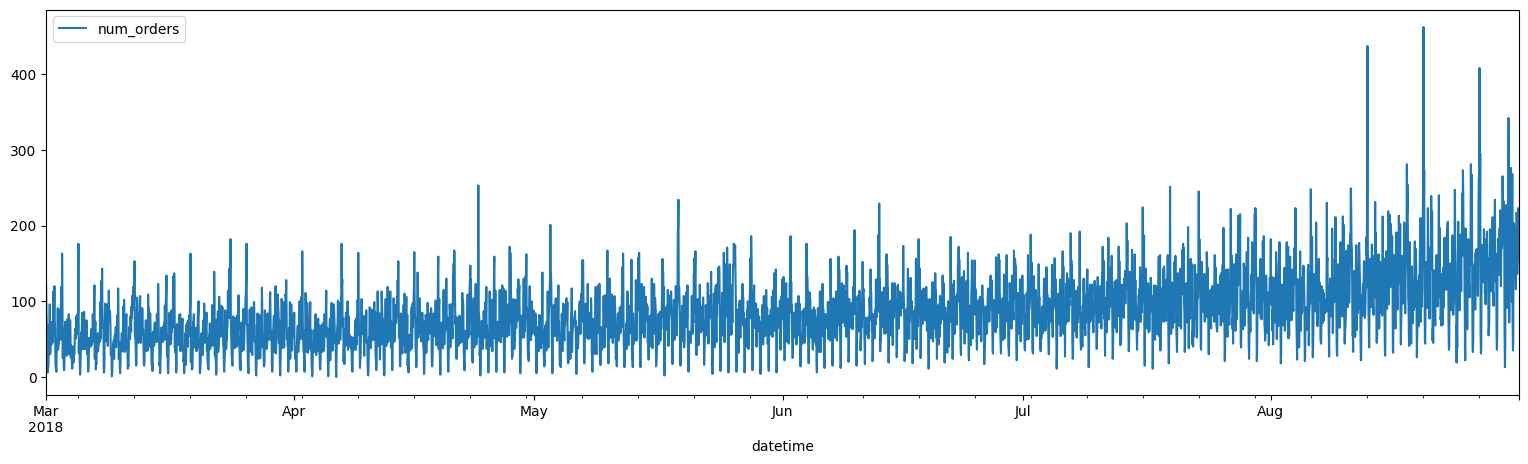

In [8]:
data.plot(figsize = (19,5));

Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

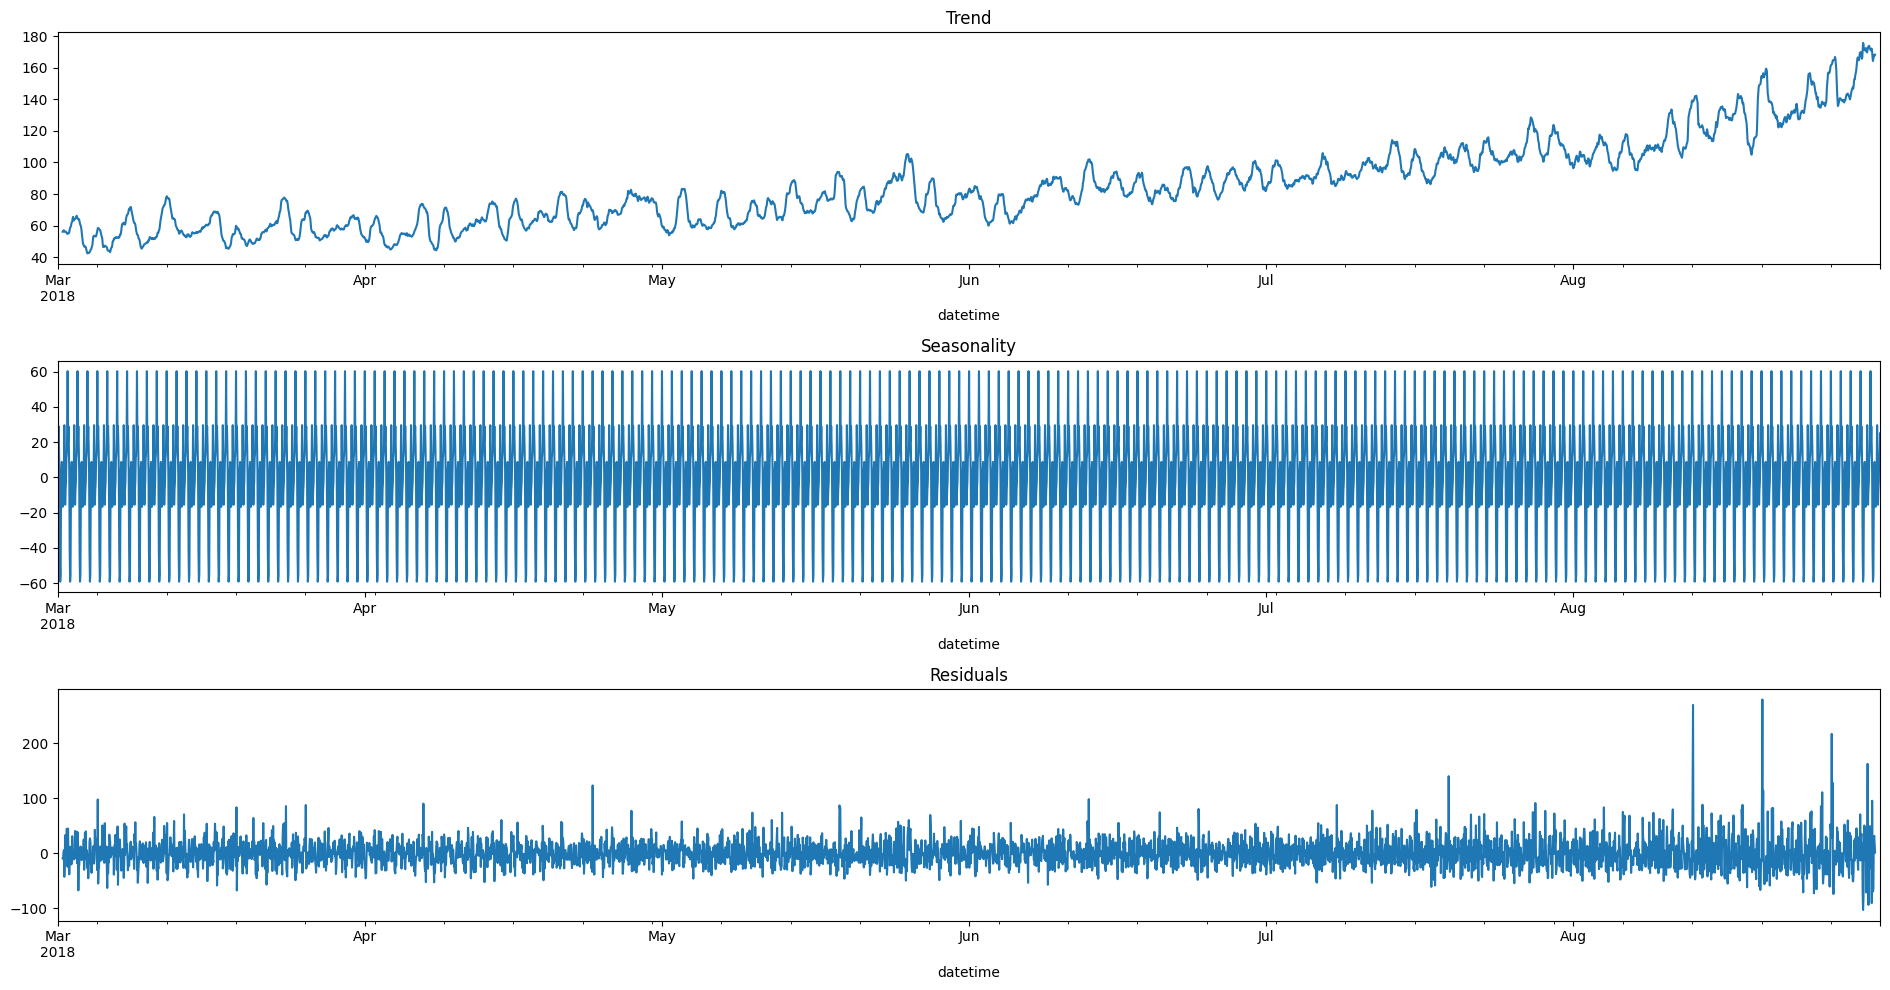

In [9]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(19,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На графике виден тренд на увеличение количества заказов ближе к концу лета. 

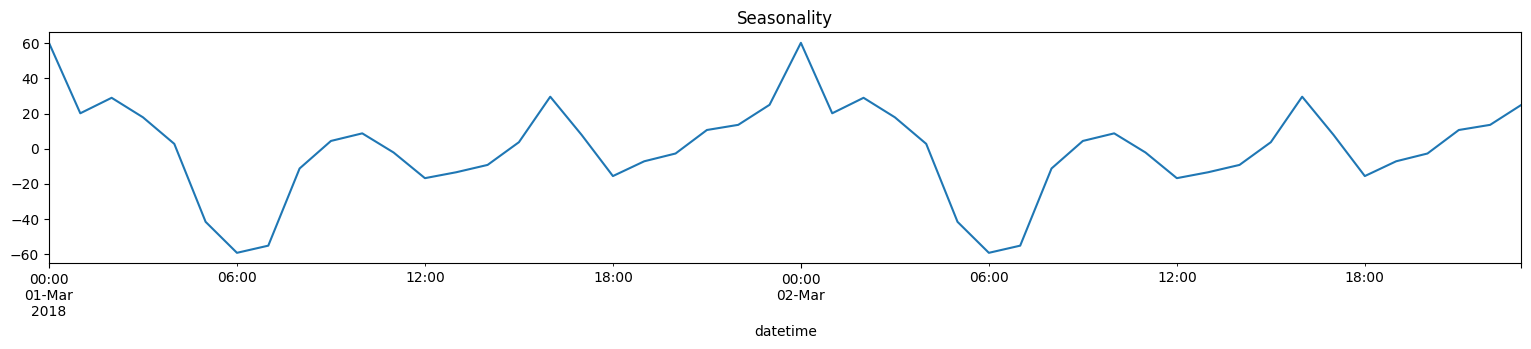

In [10]:
plt.figure(figsize=(19,3))
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality');

Сезонность просматривается в периоде одного дня.

## Обучение

Создадим новые признаки и разобьем данные на трейн и тест.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data_f = data.copy()
    data_f['dayofweek'] = data_f.index.dayofweek
    data_f['hour'] = data_f.index.hour
    
    
    for lag in range(1, max_lag + 1):
        data_f['lag_{}'.format(lag)] = data_f['num_orders'].shift(lag)
    data_f['rolling_mean'] = data_f['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(data_f, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    X_train = train.drop('num_orders', axis=1)
    y_train = train.num_orders
    X_test = test.drop('num_orders', axis=1)
    y_test = test.num_orders
    
    return X_train, y_train, X_test, y_test

Обучим три модели: LinearRegression, LGBMRegressor, CatBoostRegressor.\
Для каждой подберем оптимальные значения параметров max_lag и rolling_mean_size.\
Результаты сохраним в таблице.

In [12]:

model_param = [{'model_name': LinearRegression(), 'param_grid':{}},
               {'model_name': lgb.LGBMRegressor(metric='root_mean_squared_error', random_state=12345),
                'param_grid': {'n_estimators': range(50, 150, 50)}},
               {'model_name': CatBoostRegressor(loss_function="RMSE", verbose=False),
                'param_grid': {'n_estimators': range(50, 150, 50)}}
              ]


for i in range(len(model_param)):
    print('Подбираем гиперпараметры и обучаем', model_param[i]['model_name'])
    max_RMSE = 48
    for max_lag in range(1, 200, 10):
        for rolling_mean_size in range(24, 120, 24):
            X_train, y_train, X_test, y_test = make_features(data, max_lag, rolling_mean_size)
            
            cv=TimeSeriesSplit(n_splits=5)
            ln_params = {}
            ln_reg = GridSearchCV(model_param[i]['model_name'],
                                  model_param[i]['param_grid'],
                                  n_jobs=-1,
                                  verbose=200,
                                  cv=cv,
                                  scoring='neg_root_mean_squared_error' 
                                 )
            ln_reg.fit(X_train, y_train)
            
        
            if -ln_reg.best_score_ <= max_RMSE:
                model_param[i]['best_params'] = ln_reg.best_params_
                model_param[i]['best_score'] = -ln_reg.best_score_
                model_param[i]['max_lag'] = max_lag
                model_param[i]['rolling_mean_size'] = rolling_mean_size
                model_param[i]['model'] = ln_reg
                max_RMSE = -ln_reg.best_score_
                

Подбираем гиперпараметры и обучаем LinearRegression()
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fi

In [13]:
result = pd.DataFrame.from_dict(model_param)
result

,model_name,param_grid,best_params,best_score,max_lag,rolling_mean_size,model
0,LinearRegression(),{},{},22.584777,171,48,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra..."
1,LGBMRegressor(metric='root_mean_squared_error'...,"{'n_estimators': (50, 100)}",{'n_estimators': 50},22.965640,181,48,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra..."
2,<catboost.core.CatBoostRegressor object at 0x0...,"{'n_estimators': (50, 100)}",{'n_estimators': 100},23.592659,191,24,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra..."


Лучший результат метрики RMSE показала LinearRegression. Проверим ее на тесте.

## Тестирование

In [14]:
X_train, y_train, X_test, y_test = make_features(data, 171, 48)

In [15]:
print("RMSE тестовой выборки , lag features = 171, rolling_mean_size = 48: ",
      mean_squared_error(result['model'][0].predict(X_test), y_test, squared = False))

RMSE тестовой выборки , lag features = 171, rolling_mean_size = 48:  34.703804822681754


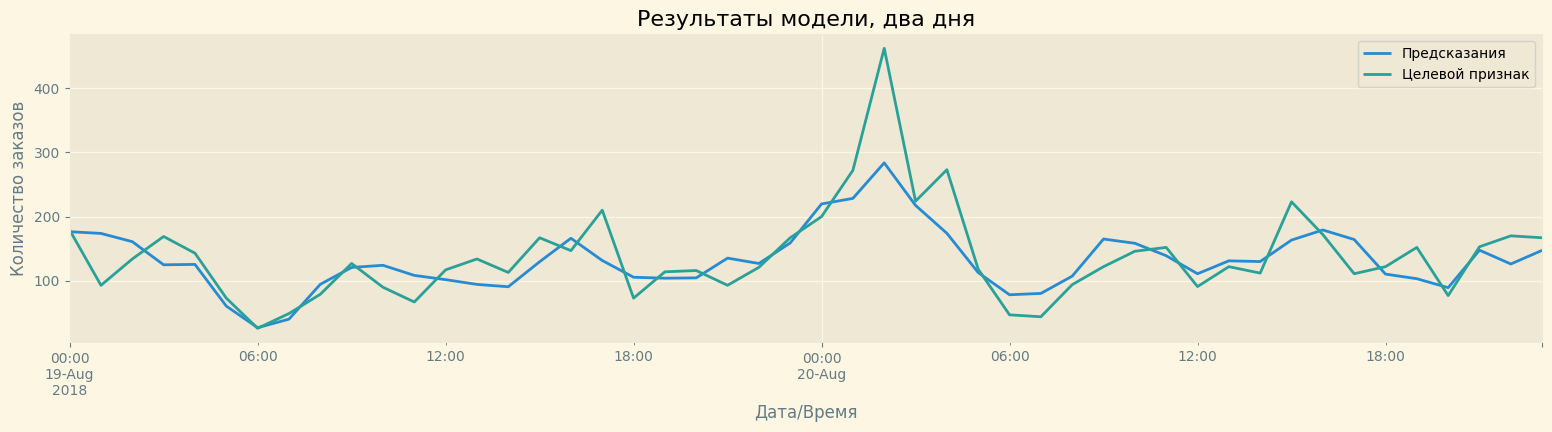

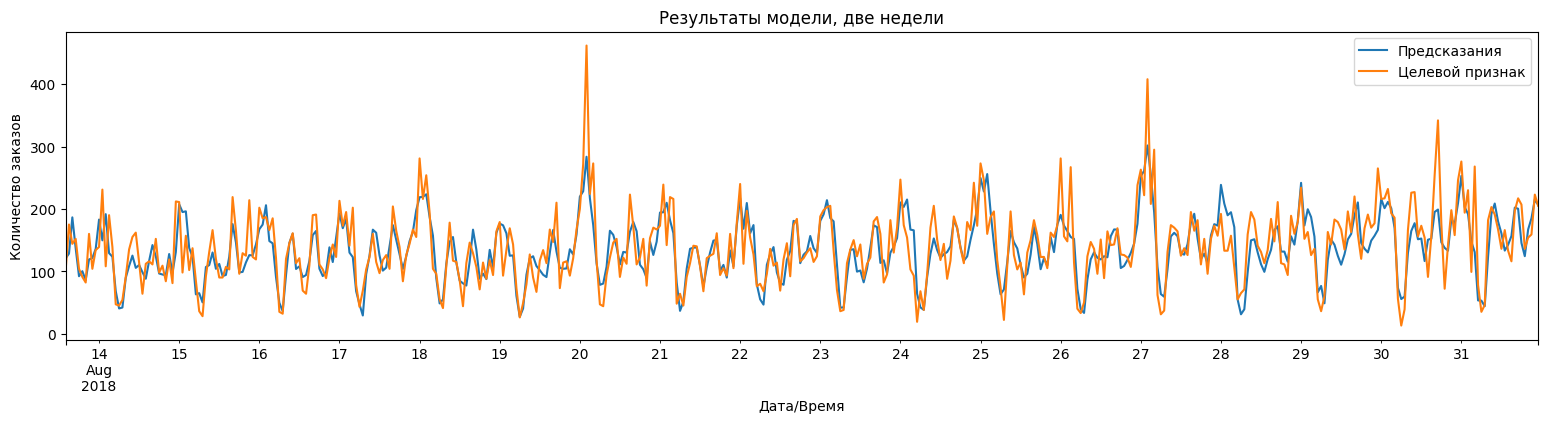

In [16]:
with plt.style.context('Solarize_Light2'):
    pd.DataFrame(result['model'][0].predict(X_test),
                 index=y_test.index)['2018-08-19':'2018-08-20'].plot(figsize= (19,4))
    y_test['2018-08-19':'2018-08-20'].plot()
    plt.title('Результаты модели, два дня')
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата/Время')
    plt.legend(['Предсказания','Целевой признак'])
    
plt.show();

pd.DataFrame(result['model'][0].predict(X_test),
             index=y_test.index).plot(figsize= (19,4))
y_test.plot()
plt.title('Результаты модели, две недели')
plt.ylabel('Количество заказов')
plt.xlabel('Дата/Время')
plt.legend(['Предсказания','Целевой признак'])

plt.show();

На графике видно, что максимальные расхождения в пиковых значениях, в основном в выходные.

**Проверим модель на адекватность**

Построим две дамми-модели. 

In [17]:
pred_median = np.ones(y_test.shape) *  y_train.median()

print("RMSE:", mean_squared_error(pred_median, y_test, squared = False))

RMSE: 86.41465855206327


In [18]:
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])
print("RMSE:", mean_squared_error(pred_previous, y_test, squared = False))

RMSE: 58.856486242815066


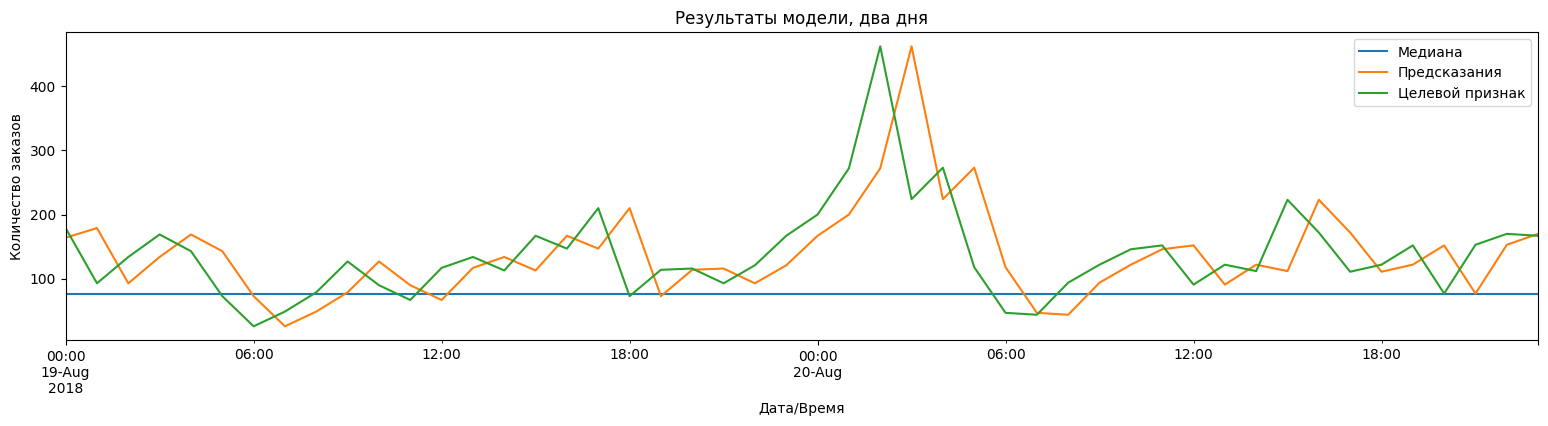

In [19]:
pd.DataFrame(pred_median, index=y_test.index)['2018-08-19':'2018-08-20'].plot(figsize= (19,4))
pred_previous['2018-08-19':'2018-08-20'].plot(figsize= (19,4))
y_test['2018-08-19':'2018-08-20'].plot()
plt.title('Результаты модели, два дня')
plt.ylabel('Количество заказов')
plt.xlabel('Дата/Время')
plt.legend(['Медиана','Предсказания','Целевой признак'])

plt.show();

## Вывод

В предоставленной выборке были данные о количестве заказов в период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00 с интервалов в 10 минут.

Было проведено ресемплирование данных по сумме с интервалом в 1 час.

Анализ данных показал тренд на увеличение количества заказов ближе к концу лета и сезонность в периоде одного дня.

Было обучено и проанализировано три модели: LinearRegressor, CatBoostRegressor и LGBMRegressor.

В данных были созданы новые признаки: день недели, час. Подобраны оптимальные размер окна скользящего среднего и количество признаков lag features.

**Лучшая модель LinearRegressor(), max_lag = 171, rolling_mean_size = 48, RMSE на тесте 34,7**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48